# E01. Gambling
This evaluates gambling projections
- Type: Evaluation
- Run Frequency: Irregular
- Sources:
    - Sportsbook Review
- Dates:
    - Created: 3/30/2024
    - Updated: 5/5/2024

### Imports

In [1]:
%run "C:\Users\james\Documents\MLB\Code\U1. Imports.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U2. Utilities.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U3. Classes.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U4. Datasets.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U5. Models.ipynb"

In [2]:
# Set option to display numbers without scientific notation
pd.set_option('display.float_format', '{:.6f}'.format)

### Dates

In [3]:
start_date = "20240101"
end_date = "20240930"
# start_date = todaysdate
# end_date = todaysdate

### Games

In [4]:
# game_df = create_games(start_date, end_date, team_map)
game_df = pd.read_pickle(os.path.join(baseball_path, "game_df.pkl"))

In [5]:
# game_df = game_df.query('game_date < "20240601"')

### Models

##### Create dataframe containing model information

In [6]:
model_dictionary = {
    "date": todaysdate,
    "batter_stats_scaler_name": "Unavailable", 
    "pitcher_stats_scaler_name": "Unavailable",
    "batter_stats_fg_scaler_name": "Unavailable", 
    "pitcher_stats_fg_scaler_name": "Unavailable",
    "batter_imputations_model_name": "Unavailable", 
    "pitcher_imputations_model_name": "Unavailable", 
    "model_binary_name": "Unavailable", 
    "model_outs_name": "Unavailable", 
    "model_safe_name": "Unavailable",
    "model_errors_name": "Unavailable", 
    "model_dp_name": "Unavailable", 
    "model_out_bases_name": "Unavailable", 
    "model_events_name": "Unavailable", 
    "model_date": "Unavailable", 
    "model_pulls_name": "Unavailable",
    "model_sba_2b_name": "Unavailable", 
    "model_sba_3b_name": "Unavailable", 
    "model_sb_2b_name": "Unavailable", 
    "model_sb_3b_name": "Unavailable",
}

model_df = pd.DataFrame([model_dictionary])

In [7]:
# model_df = pd.DataFrame()

# Functions

##### Calculate gambling stats for sims

In [8]:
def gambling_stats_sim(df):
    ### OU
    # Sim total
    df['total_proj'] = df[['away_score', 'home_score']].sum(axis=1)
    # Sim suggests the over
    df['over_proj'] = (df['total_proj'] > df['OU']).astype('int')
    # Sim suggests the under
    df['under_proj'] = (df['total_proj'] < df['OU']).astype('int')
    # Sim suggests push
    df['push_proj'] = (df['total_proj'] == df['OU']).astype('int')

    # Actual total
    df['total_act'] = df[['away_score_act', 'home_score_act']].sum(axis=1)
    # Over hits
    df['over_act'] = (df['total_act'] > df['OU']).astype('int')
    # Under hits
    df['under_act'] = (df['total_act'] < df['OU']).astype('int')
    # Push
    df['push_act'] = (df['total_act'] == df['OU']).astype('int')
    
    ### Spread
    # Sim projects away covers
    df['away_sp_proj'] = (df['away_score'] > (df['home_score'] + df['Spread'])).astype('int')
    # Sim projects home covers
    df['home_sp_proj'] = (df['away_score'] < (df['home_score'] + df['Spread'])).astype('int')
    # Sim projects push
    df['push_sp_proj'] = (df['away_score'] == (df['home_score'] + df['Spread'])).astype('int')

    # Away team covers
    df['away_sp_act'] = (df['away_score_act'] > (df['home_score_act'] + df['Spread'])).astype('int')
    # Home team covers
    df['home_sp_act'] = (df['away_score_act'] < (df['home_score_act'] + df['Spread'])).astype('int')
    # Push
    df['push_sp_act'] = (df['away_score_act'] == (df['home_score_act'] + df['Spread'])).astype('int')
    
    
    ### ML
    # Sim projects away team wins
    df['away_ml_proj'] = (df['away_score'] > df['home_score']).astype('int')
    # Sim projects home team wins
    df['home_ml_proj'] = (df['away_score'] < df['home_score']).astype('int')

    # Away team wins
    df['away_ml_act'] = (df['away_score_act'] > df['home_score_act']).astype('int')
    # Home team wins
    df['home_ml_act'] = (df['away_score_act'] < df['home_score_act']).astype('int')
    
    # Convert to numeric
    df['away_score_act'] = df['away_score_act'].astype('int')
    df['home_score_act'] = df['home_score_act'].astype('int')


    df_grouped = df.groupby(['game_id', 'venue_id', 'game_type', 'status', 'game_num', 'away_team', 'home_team']).mean(numeric_only=True).reset_index()
    

    return df_grouped

##### Convert American odds to payout multipliers

In [9]:
def multipliers(odds):
    if odds == 0:
        return np.nan
    
    elif odds > 0:
        mult = odds / 100 + 1
    else: 
        mult = 100 / odds * - 1 + 1
        
    return mult

##### Calculate gambling stats for matchups

In [10]:
def gambling_stats_games(df):
    # Calculate gambling stats for sims
    df_grouped = gambling_stats_sim(df)
    

    # Convert American odds to multipliers
    for col in ['SpreadMoney1', 'SpreadMoney2', 'OuMoney1', 'OuMoney2', 'MLMoney1', 'MLMoney2']:
        df_grouped[f"{col}_usa"] = df_grouped[col]
        df_grouped[col] = df_grouped[col].apply(multipliers)

    ### Calculate predicted payouts
    # Spreads
    df_grouped['AwaySpreadPred'] = df_grouped['SpreadMoney1'] * df_grouped['away_sp_proj'] + df_grouped['push_sp_proj']
    df_grouped['HomeSpreadPred'] = df_grouped['SpreadMoney2'] * df_grouped['home_sp_proj'] + df_grouped['push_sp_proj']

    # Over/Unders
    df_grouped['OverPred'] = df_grouped['OuMoney1'] * df_grouped['over_proj'] + df_grouped['push_proj']
    df_grouped['UnderPred'] = df_grouped['OuMoney2'] * df_grouped['under_proj'] + df_grouped['push_proj']

    # ML
    df_grouped['AwayMLPred'] = df_grouped['MLMoney1'] * df_grouped['away_ml_proj']
    df_grouped['HomeMLPred'] = df_grouped['MLMoney2'] * df_grouped['home_ml_proj']

    ### Calculate actual payouts
    # Spreads
    df_grouped['AwaySpreadAct'] = df_grouped['SpreadMoney1'] * df_grouped['away_sp_act']
    df_grouped['HomeSpreadAct'] = df_grouped['SpreadMoney2'] * df_grouped['home_sp_act']
    # Adjust for pushes
    df_grouped['AwaySpreadAct'] = np.where(df_grouped['push_sp_act'] == 1, 1, df_grouped['AwaySpreadAct'])
    df_grouped['HomeSpreadAct'] = np.where(df_grouped['push_sp_act'] == 1, 1, df_grouped['HomeSpreadAct'])
    

    # Over/Unders
    df_grouped['OverAct'] = df_grouped['OuMoney1'] * df_grouped['over_act']
    df_grouped['UnderAct'] = df_grouped['OuMoney2'] * df_grouped['under_act']
    # Adjust for pushes
    df_grouped['OverAct'] = np.where(df_grouped['OU'] == df_grouped['total_act'], 1, df_grouped['OverAct'])
    df_grouped['UnderAct'] = np.where(df_grouped['OU'] == df_grouped['total_act'], 1, df_grouped['UnderAct'])

    # ML
    df_grouped['AwayMLAct'] = df_grouped['MLMoney1'] * df_grouped['away_ml_act']
    df_grouped['HomeMLAct'] = df_grouped['MLMoney2'] * df_grouped['home_ml_act']


    ### Pick bets
    # Spread
    df_grouped['SpreadPick'] = np.where(df_grouped['AwaySpreadPred'] >= 1, "Away", "Home")
    df_grouped['SpreadPick'] = np.where((df_grouped['AwaySpreadPred'] < 1) & (df_grouped['HomeSpreadPred'] < 1), "Neither", df_grouped['SpreadPick'])

    # Over/Under
    df_grouped['OverUnderPick'] = np.where(df_grouped['UnderPred'] >= 1, "Under", "Over")
    df_grouped['OverUnderPick'] = np.where((df_grouped['UnderPred'] < 1) & (df_grouped['OverPred'] < 1), "Neither", df_grouped['OverUnderPick'])

    # ML
    df_grouped['MLPick'] = np.where(df_grouped['AwayMLPred'] >= 1, "Away", "Home")
    df_grouped['MLPick'] = np.where((df_grouped['AwayMLPred'] < 1) & (df_grouped['HomeMLPred'] < 1), "Neither", df_grouped['MLPick'])


    ### Calculate winnings
    # Spread
    df_grouped['SpreadPayout'] = np.where(df_grouped['SpreadPick'] == "Away", df_grouped['AwaySpreadAct'], df_grouped['HomeSpreadAct'])
    df_grouped['SpreadPayout'] = np.where(df_grouped['SpreadPick'] == "Neither", np.nan, df_grouped['SpreadPayout'])

    # Over/Under
    df_grouped['OverUnderPayout'] = np.where(df_grouped['OverUnderPick'] == "Under", df_grouped['UnderAct'], df_grouped['OverAct'])
    df_grouped['OverUnderPayout'] = np.where(df_grouped['OverUnderPick'] == "Neither", np.nan, df_grouped['OverUnderPayout'])

    # ML
    df_grouped['MLPayout'] = np.where(df_grouped['MLPick'] == "Away", df_grouped['AwayMLAct'], df_grouped['HomeMLAct'])
    df_grouped['MLPayout'] = np.where(df_grouped['MLPick'] == "Neither", np.nan, df_grouped['MLPayout'])
    
    
    df_grouped['SpreadPayoutPred'] = np.where(df_grouped['AwaySpreadPred'] > 1, df_grouped['AwaySpreadPred'], df_grouped['HomeSpreadPred'])
    df_grouped['SpreadPayoutPred'] = np.where(df_grouped['SpreadPayoutPred'] < 1, np.nan, df_grouped['SpreadPayoutPred'])
    
    df_grouped['OverUnderPayoutPred'] = np.where(df_grouped['OverPred'] > 1, df_grouped['OverPred'], df_grouped['UnderPred'])
    df_grouped['OverUnderPayoutPred'] = np.where(df_grouped['OverUnderPayoutPred'] < 1, np.nan, df_grouped['OverUnderPayoutPred'])
    
    df_grouped['MLPayoutPred'] = np.where(df_grouped['AwayMLPred'] > 1, df_grouped['AwayMLPred'], df_grouped['HomeMLPred'])
    df_grouped['MLPayoutPred'] = np.where(df_grouped['MLPayoutPred'] < 1, np.nan, df_grouped['MLPayoutPred'])
    
    
    return df_grouped

##### Calculate errors and squared errors

In [11]:
def vegas_runs(gambling_df):
    gambling_df.rename(columns={'away_score': 'VisitorModelRuns', 'home_score': 'HomeModelRuns'}, inplace=True)

    gambling_df['VisitorModelError'] = gambling_df['VisitorModelRuns'] - gambling_df['away_score_act']
    gambling_df['VisitorVegasError'] = gambling_df['VisitorVegasRuns'] - gambling_df['away_score_act']

    gambling_df['VisitorModelSqError'] = gambling_df['VisitorModelError'] ** 2
    gambling_df['VisitorVegasSqError'] = gambling_df['VisitorVegasError'] ** 2

    gambling_df['HomeModelError'] = gambling_df['HomeModelRuns'] - gambling_df['home_score_act']
    gambling_df['HomeVegasError'] = gambling_df['HomeVegasRuns'] - gambling_df['home_score_act']

    gambling_df['HomeModelSqError'] = gambling_df['HomeModelError'] ** 2
    gambling_df['HomeVegasSqError'] = gambling_df['HomeVegasError'] ** 2
    
    # Total runs
    gambling_df['total_act'] = gambling_df['away_score_act'] + gambling_df['home_score_act']
    gambling_df['TotalVegasRuns'] = gambling_df['VisitorVegasRuns'] + gambling_df['HomeVegasRuns']

    return gambling_df

##### Determine spread side

In [12]:
def determine_spread_side(row):
    if (row['SpreadPick'] == 'Away' and row['Spread'] < 0) or (row['SpreadPick'] == 'Home' and row['Spread'] > 0):
        return 'Underdog'
    elif (row['SpreadPick'] == 'Away' and row['Spread'] > 0) or (row['SpreadPick'] == 'Home' and row['Spread'] < 0):
        return 'Favorite'
    else:
        return 'Neither'

##### Impute Vegas runs

Methodology:
- Calculate win probabilities using ML payouts
- Assign runs from O/U using win probability

Limitations:
- Using win probability to assign runs is imperfect
- Ignores different payouts for overs and unders

In [13]:
def impute_runs(df):
    ### Implied Odds
    # Odds calculated from lines
    df['Win1_A'] = np.where(df['MLMoney1'] > 0, 100 / (df['MLMoney1'] + 100), -df['MLMoney1'] / (-df['MLMoney1'] + 100))
    df['Win2_A'] = np.where(df['MLMoney2'] > 0, 100 / (df['MLMoney2'] + 100), -df['MLMoney2'] / (-df['MLMoney2'] + 100))
    
    # Odds derived from calculations above
    df['Win1_B'] = 1 - df['Win2_A']
    df['Win2_B'] = 1 - df['Win1_A']
    
    # Odds calculated by averaging two calculations
    df['Win1'] = df[['Win1_A', 'Win1_B']].mean(axis=1)
    df['Win2'] = df[['Win2_A', 'Win2_B']].mean(axis=1)
    
    
    ### Implied Runs (Multiplied by constants, roughly adjusting for the fact that half of games do not go into the bottom of the 9th)
    df['VisitorVegasRuns'] = df['OU'] * df['Win1'] * (9/17.5/0.5)
    df['HomeVegasRuns'] = df['OU'] * df['Win2'] * (8.5/17.5/0.5)
    
    
    return df

##### Create dataset

In [14]:
def gambling_dataset(game_df, team_map, date, impute=True):
    ### Odds
    # Read in odds
    odds_df = pd.read_csv(os.path.join(baseball_path, "A08. Odds Sportsbook Review", f"Odds {date}.csv"))
    
    # Impute runs
    if impute == True:
        odds_df = impute_runs(odds_df)
       
    # Identify which game comes first
    odds_df.sort_values(by=['VisitorTeamShort', 'EventDateTime'], inplace=True)
    odds_df['game_num'] = odds_df.groupby(['VisitorTeamShort']).cumcount()+1
    # Convert to string
    odds_df['date'] = odds_df['date'].astype('str')                  
    
    # Merge in team abbreviation
    odds_df = odds_df.merge(team_map[['SBRTEAM', 'BBREFTEAM']], left_on=['HomeTeamShort'], right_on=['SBRTEAM'], how='left')
    
    
    
    ### Simulations
    # Subset daily games
    daily_game_df = game_df[game_df['date'] == date].reset_index(drop=True)
    # Create list of dataframes
    gambling_df_list = []
    
    # Loop over games
    for i in range(len(daily_game_df)):
        # Extract date and game_id
        date, game_id = daily_game_df['date'][i], daily_game_df['game_id'][i]
        
        if os.path.exists(os.path.join(baseball_path, "B02. Simulations", "1. Game Sims", f"Matchups {date}", f"game_{game_id}.csv")):
            # Read in game simulations
            simulation_df = pd.read_csv(os.path.join(baseball_path, "B02. Simulations", "1. Game Sims", f"Matchups {date}", f"game_{game_id}.csv"))
            # Add game_id for merging
            simulation_df['game_id'] = game_id
            
            ### Merge in game_df
            gambling_df = pd.merge(simulation_df, game_df[['game_id', 'away_score', 'home_score', 'venue_id', 'game_type', 'status', 'game_num', 
                                                           'away_team', 'home_team']], on=['game_id'], how='left', suffixes=('', '_act'))
            
            ### Merge in odds_df
            gambling_df = pd.merge(gambling_df, odds_df, left_on=['home_team', 'game_num'], right_on=['BBREFTEAM', 'game_num'], how='left')
            
            # Calculate Gambling Stats
            gambling_df = gambling_stats_games(gambling_df)
            gambling_df['SpreadSide'] = gambling_df.apply(determine_spread_side, axis=1)
            # Create run error stats
            gambling_df = vegas_runs(gambling_df)
            # Append to list
            gambling_df_list.append(gambling_df)
            
        else:
            pass
        
    # Concatenate all game gambling stats together
    daily_gambling_df = pd.concat(gambling_df_list, axis=0)
    daily_gambling_df.reset_index(inplace=True, drop=True)
    
    # Add date
    daily_gambling_df['date'] = date
        
    return daily_gambling_df

##### Graphs

In [15]:
def payout_plotter(gambling_df, bet, range_width=0.1, ax=None):
    gambling_df[f'{bet}PayoutGroup'] = gambling_df[f'{bet}PayoutPred'] // range_width * range_width

    # Group by SpreadPayoutGroup and calculate the average SpreadMoney for each group
    grouped_data = gambling_df.groupby(f'{bet}PayoutGroup')[f'{bet}Payout'].mean().reset_index()

    # Use existing axis if provided, otherwise create a new subplot
    if ax is None:
        fig, ax = plt.subplots(figsize=(4, 4))

    # Create a scatter plot
    ax.scatter(grouped_data[f'{bet}PayoutGroup'], grouped_data[f'{bet}Payout'], color='blue', alpha=0.7)

    # Set specific axis limits and ticks with intervals of 0.1
    ax.set_xlim(0.8, 2.0)
    ax.set_xticks(np.arange(0.7, 2.1, 0.1))
    ax.set_ylim(0.8, 2.0)
    ax.set_yticks(np.arange(0.7, 2.1, 0.1))

    ax.set_title(f'Average {bet}PayoutPred vs {bet}Payout')
    ax.set_xlabel(f'{bet}PayoutGroup')
    ax.set_ylabel(f'Average {bet}PayoutPred')
    ax.grid(True)

##### Significance Test

In [16]:
def significance_test(df, bet, threshold, alpha=0.05):
    # Accepted bets
    bet_list = ['OverUnder', 'Spread', 'ML']
    if bet not in bet_list:
        print(f"{bet} not an approved bet type. Did you mean one of: {bet_list}?")
        return
    
    # Extract bets within threshold
    test_list = list(df.query(f'{bet}PayoutPred >= {threshold}')[f'{bet}Payout'])
    test_list = [x for x in test_list if not math.isnan(x)]
    
    # Calculate average payout and sample size
    average_payout = round(np.mean(test_list), 5)
    sample_size = len(test_list)
    
    # Calculate the average of the list and perform a one-sample t-test
    t_statistic, p_value_two_sided = stats.ttest_1samp(test_list, 1)
    
    
    # For a one-sided test (H1: mean > mu), divide the p-value by 2
    if t_statistic > 0:
        p_value = p_value_two_sided / 2
    else:
        p_value = 1.0  # If t-stat is negative, the p-value is 1
    

    # Determine significance
    if p_value < alpha:
        significant = "Yes"
    else:
        significant = "No"
    
    
    return average_payout, sample_size, p_value, significant

### Dataset

Identify list of dates to include

In [17]:
date_list = list(game_df['date'].unique())

Create all daily gambling files and append them together

In [18]:
def gambling_dataset2(game_df, team_map, date, impute=True):
    try:
        daily_gambling_df = gambling_dataset(game_df, team_map, date, impute)
    except:
        daily_gambling_df = None
        
    return daily_gambling_df


In [19]:
%%time
daily_gambling_dfs_list = Parallel(n_jobs=-1)(delayed(gambling_dataset2)(game_df=game_df, team_map=team_map, date=date, impute=True) for date in date_list)
complete_gambling_df = pd.concat(daily_gambling_dfs_list, axis=0)
complete_gambling_df.head()

CPU times: total: 4.27 s
Wall time: 13.8 s


,game_id,venue_id,game_type,status,game_num,away_team,home_team,VisitorModelRuns,HomeModelRuns,away_score_act,home_score_act,Spread,OU,SpreadMoney1,SpreadMoney2,OuMoney1,OuMoney2,MLMoney1,MLMoney2,VisitorVegasRuns,HomeVegasRuns,Win1_A,Win2_A,Win1_B,Win2_B,Win1,Win2,total_proj,over_proj,under_proj,push_proj,total_act,over_act,under_act,push_act,away_sp_proj,home_sp_proj,push_sp_proj,away_sp_act,home_sp_act,push_sp_act,away_ml_proj,home_ml_proj,away_ml_act,home_ml_act,SpreadMoney1_usa,SpreadMoney2_usa,OuMoney1_usa,OuMoney2_usa,MLMoney1_usa,MLMoney2_usa,AwaySpreadPred,HomeSpreadPred,OverPred,UnderPred,AwayMLPred,HomeMLPred,AwaySpreadAct,HomeSpreadAct,OverAct,UnderAct,AwayMLAct,HomeMLAct,SpreadPick,OverUnderPick,MLPick,SpreadPayout,OverUnderPayout,MLPayout,SpreadPayoutPred,OverUnderPayoutPred,MLPayoutPred,SpreadSide,VisitorModelError,VisitorVegasError,VisitorModelSqError,VisitorVegasSqError,HomeModelError,HomeVegasError,HomeModelSqError,HomeVegasSqError,TotalVegasRuns,date
0,745444,5150,R,Final,1,LAD,SDP,15.000000,6.000000,5.000000,2.000000,1.500000,8.500000,1.869565,1.952381,1.769231,2.000000,1.526316,2.550000,5.521182,3.042693,0.655172,0.392157,0.607843,0.344828,0.631508,0.368492,21.000000,1.000000,0.000000,0.000000,7.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,-115.000000,-105.000000,-130.000000,100.000000,-190.000000,155.000000,1.869565,0.000000,1.769231,0.000000,1.526316,0.000000,1.869565,0.000000,0.000000,2.000000,1.526316,0.000000,Away,Over,Away,1.869565,0.000000,1.526316,1.869565,1.769231,1.526316,Favorite,10.000000,0.521182,100.000000,0.271631,4.000000,1.042693,16.000000,1.087209,8.563875,20240320
0,746175,5150,R,Final,1,SDP,LAD,5.000000,7.000000,15.000000,11.000000,-1.500000,8.500000,1.800000,2.050000,1.833333,2.000000,2.550000,1.526316,3.221675,5.214450,0.392157,0.655172,0.344828,0.607843,0.368492,0.631508,12.000000,1.000000,0.000000,0.000000,26.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-125.000000,105.000000,-120.000000,100.000000,155.000000,-190.000000,0.000000,2.050000,1.833333,0.000000,0.000000,1.526316,1.800000,0.000000,1.833333,0.000000,2.550000,0.000000,Home,Over,Home,0.000000,1.833333,0.000000,2.050000,1.833333,1.526316,Favorite,-10.000000,-11.778325,100.000000,138.728943,-4.000000,-5.785550,16.000000,33.472590,8.436125,20240321
0,747060,2,R,Final,1,LAA,BAL,6.000000,4.000000,3.000000,11.000000,-1.500000,7.500000,1.740741,2.100000,1.869565,1.952381,2.550000,1.526316,2.842654,4.600985,0.392157,0.655172,0.344828,0.607843,0.368492,0.631508,10.000000,1.000000,0.000000,0.000000,14.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-135.000000,110.000000,-115.000000,-105.000000,155.000000,-190.000000,1.740741,0.000000,1.869565,0.000000,2.550000,0.000000,0.000000,2.100000,1.869565,0.000000,0.000000,1.526316,Away,Over,Away,0.000000,1.869565,0.000000,1.740741,1.869565,2.550000,Underdog,3.000000,-0.157346,9.000000,0.024758,-7.000000,-6.399015,49.000000,40.947390,7.443640,20240328
1,746737,2602,R,Final,1,WSN,CIN,7.000000,4.000000,2.000000,8.000000,-1.500000,9.000000,1.645161,2.250000,1.909091,1.909091,2.300000,1.645161,3.827548,5.127950,0.434783,0.607843,0.392157,0.565217,0.413470,0.586530,11.000000,1.000000,0.000000,0.000000,10.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-155.000000,125.000000,-110.000000,-110.000000,130.000000,-155.000000,1.645161,0.000000,1.909091,0.000000,2.300000,0.000000,0.000000,2.250000,1.909091,0.000000,0.000000,1.645161,Away,Over,Away,0.000000,1.909091,0.000000,1.645161,1.909091,2.300000,Underdog,5.000000,1.827548,25.000000,3.339933,-4.000000,-2.872050,16.000000,8.248669,8.955499,20240328
2,745445,2680,R,Final,1,SFG,SDP,3.000000,4.000000,4.000000,6.000000,-1.500000,7.500000,1.476190,2.700

##### Clean

In [20]:
# May require cleaning later. At the moment, it's fine.

In [21]:
complete_gambling_df.shape, complete_gambling_df[complete_gambling_df['game_type'] == "R"].shape, complete_gambling_df.drop_duplicates(subset=['game_id']).shape

((2434, 83), (2429, 83), (2434, 83))

In [22]:
complete_gambling_df['ModelMargin'] = abs(complete_gambling_df['VisitorModelRuns'] - complete_gambling_df['HomeModelRuns'])
complete_gambling_df['VegasMargin'] = abs(complete_gambling_df['VisitorVegasRuns'] - complete_gambling_df['HomeVegasRuns'])

In [23]:
complete_gambling_df.query('VegasMargin < 5')[['ModelMargin', 'VegasMargin']].describe()

,ModelMargin,VegasMargin
count,2361.000000,2361.000000
mean,3.321808,1.224079
std,2.544092,0.933794
min,0.035000,0.018752
25%,1.000000,0.483644
50%,3.000000,1.015873
75%,5.000000,1.764411
max,17.000000,4.857143


In [24]:
# complete_gambling_df.query('VegasMargin > 3').query('ModelMargin < 1')[['date', 'MLMoney1_usa', 'MLMoney2_usa', 'away_team', 'home_team', 'VisitorModelRuns', 'HomeModelRuns', 'VisitorVegasRuns', 'HomeVegasRuns', 'away_score_act', 'home_score_act']]

### 1. Profitability

##### Graph by Bin

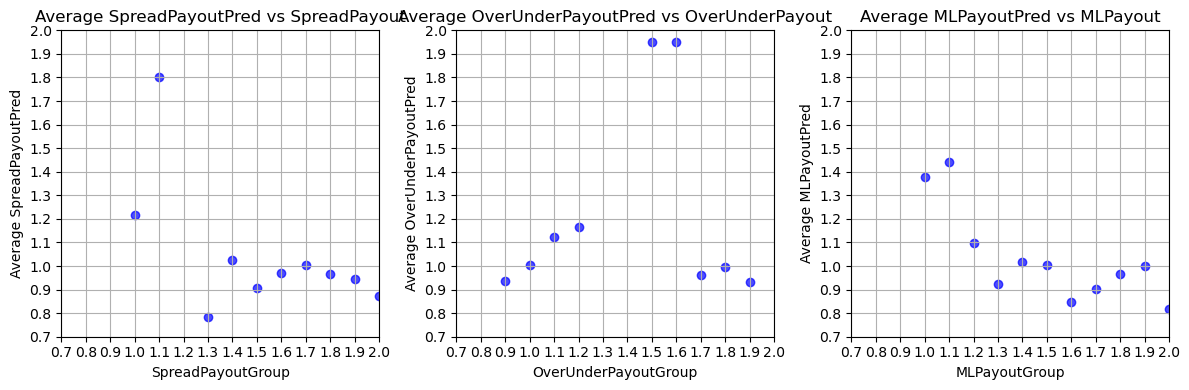

			Spread: 0.958					OverUnder: 0.956				Money Line: 0.926


In [25]:
# Create a single row with three subplots
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Call the function for each subplot
payout_plotter(complete_gambling_df, 'Spread', ax=axes[0])
payout_plotter(complete_gambling_df, 'OverUnder', ax=axes[1])
payout_plotter(complete_gambling_df, 'ML', ax=axes[2])

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()

SpreadMean = complete_gambling_df['SpreadPayout'].mean()
OverUnderMean = complete_gambling_df['OverUnderPayout'].mean()
MLMean = complete_gambling_df['MLPayout'].mean()
print(f"\t\t\tSpread: {round(SpreadMean, 3)}\t\t\t\t\tOverUnder: {round(OverUnderMean, 3)}\t\t\t\tMoney Line: {round(MLMean, 3)}")

##### Significance Test

Main Bets

In [26]:
average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df, "Spread", 1.0, 0.05)
print("Spread:    ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")

average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df, "OverUnder", 1.0, 0.05)
print("OverUnder: ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")

average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df, "ML", 1.0, 0.05)
print("ML:        ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")

Spread:     Average Payout: 0.95765, Sample Size: 2353, P-Value: 1.0, Significant: No
OverUnder:  Average Payout: 0.95638, Sample Size: 2353, P-Value: 1.0, Significant: No
ML:         Average Payout: 0.92605, Sample Size: 2349, P-Value: 1.0, Significant: No


Spread

In [27]:
average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df, "Spread", 1.0, 0.05)
print("Spread:    ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
sp_list = [average_payout, sample_size, p_value, significant]

average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df.query('SpreadSide == "Underdog"'), "Spread", 1.0, 0.05)
print("Underdog:  ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
sp_underdog_list = [average_payout, sample_size, p_value, significant]

average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df.query('SpreadSide == "Favorite"'), "Spread", 1.0, 0.05)
print("Favorite:  ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
sp_favorite_list = [average_payout, sample_size, p_value, significant]

Spread:     Average Payout: 0.95765, Sample Size: 2353, P-Value: 1.0, Significant: No
Underdog:   Average Payout: 0.95132, Sample Size: 1429, P-Value: 1.0, Significant: No
Favorite:   Average Payout: 0.96745, Sample Size: 924, P-Value: 1.0, Significant: No


Over/Under

In [28]:
average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df, "OverUnder", 1.0, 0.05)
print("OverUnder: ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
ou_list = [average_payout, sample_size, p_value, significant]

average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df.query('OverUnderPick == "Over"'), "OverUnder", 1.0, 0.05)
print("Over:      ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
ou_over_list = [average_payout, sample_size, p_value, significant]

average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df.query('OverUnderPick == "Under"'), "OverUnder", 1.0, 0.05)
print("Under:     ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
ou_under_list = [average_payout, sample_size, p_value, significant]

OverUnder:  Average Payout: 0.95638, Sample Size: 2353, P-Value: 1.0, Significant: No
Over:       Average Payout: 0.9748, Sample Size: 1127, P-Value: 1.0, Significant: No
Under:      Average Payout: 0.93945, Sample Size: 1226, P-Value: 1.0, Significant: No


Moneyline

In [29]:
average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df, "ML", 1.0, 0.05)
print("ML:        ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
ml_list = [average_payout, sample_size, p_value, significant]

average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df.query('MLPick == "Away"'), "ML", 1.0, 0.05)
print("ML - Away: ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
ml_away_list = [average_payout, sample_size, p_value, significant]

average_payout, sample_size, p_value, significant = significance_test(complete_gambling_df.query('MLPick == "Home"'), "ML", 1.0, 0.05)
print("ML - Home: ", f"Average Payout: {average_payout}, Sample Size: {sample_size}, P-Value: {p_value}, Significant: {significant}")
ml_home_list = [average_payout, sample_size, p_value, significant]

ML:         Average Payout: 0.92605, Sample Size: 2349, P-Value: 1.0, Significant: No
ML - Away:  Average Payout: 0.93708, Sample Size: 1154, P-Value: 1.0, Significant: No
ML - Home:  Average Payout: 0.91539, Sample Size: 1195, P-Value: 1.0, Significant: No


Note: Frequencies of each bet can be obtained from this

##### Log 

In [30]:
profitability_dictionary = {
    "Spread": sp_list[0],
    "Spread n": sp_list[1],
    "Spread p": sp_list[2],
    "Spread YN": sp_list[3],
    "Underdog": sp_underdog_list[0],
    "Underdog n": sp_underdog_list[1],
    "Underdog p": sp_underdog_list[2],
    "Underdog YN": sp_underdog_list[3],
    "Favorite": sp_favorite_list[0],
    "Favorite n": sp_favorite_list[1],
    "Favorite p": sp_favorite_list[2],
    "Favorite YN": sp_favorite_list[3],
    "OU": ou_list[0],
    "OU n": ou_list[1],
    "OU p": ou_list[2],
    "OU YN": ou_list[3],
    "Over": ou_over_list[0],
    "Over n": ou_over_list[1],
    "Over p": ou_over_list[2],
    "Over YN": ou_over_list[3],
    "Under": ou_under_list[0],
    "Under n": ou_under_list[1],
    "Under p": ou_under_list[2],
    "Under YN": ou_under_list[3],
    "ML": ml_list[0],
    "ML n": ml_list[1],
    "ML p": ml_list[2],
    "ML YN": ml_list[3],
    "Away": ml_away_list[0],
    "Away n": ml_away_list[1],
    "Away p": ml_away_list[2],
    "Away YN": ml_away_list[3],
    "Home": ml_home_list[0],
    "Home n": ml_home_list[1],
    "Home p": ml_home_list[2],
    "Home YN": ml_home_list[3]
}

In [31]:
# Create dataframe
profitability_df = pd.DataFrame([profitability_dictionary])
# Concatenate model information
profitability_df = pd.concat([model_df, profitability_df], axis=1)
# Write to csv
profitability_df.to_csv(os.path.join(baseball_path, "C01. Gambling", "1. Profitability", f"Profitability Log {todaysdate}.csv"), index=False)

### 2. Scoring

Victory Margin

In [32]:
# Calculate average score differential between teams
# I tend to predict closer matchups, so I'd like to try to better replicate Vegas
complete_gambling_df['ModelDiff'] = (complete_gambling_df['VisitorModelRuns'] - complete_gambling_df['HomeModelRuns']).abs()
complete_gambling_df['VegasDiff'] = (complete_gambling_df['VisitorVegasRuns'] - complete_gambling_df['HomeVegasRuns']).abs()
complete_gambling_df.describe()

,game_id,venue_id,game_num,VisitorModelRuns,HomeModelRuns,away_score_act,home_score_act,Spread,OU,SpreadMoney1,SpreadMoney2,OuMoney1,OuMoney2,MLMoney1,MLMoney2,VisitorVegasRuns,HomeVegasRuns,Win1_A,Win2_A,Win1_B,Win2_B,Win1,Win2,total_proj,over_proj,under_proj,push_proj,total_act,over_act,under_act,push_act,away_sp_proj,home_sp_proj,push_sp_proj,away_sp_act,home_sp_act,push_sp_act,away_ml_proj,home_ml_proj,away_ml_act,home_ml_act,SpreadMoney1_usa,SpreadMoney2_usa,OuMoney1_usa,OuMoney2_usa,MLMoney1_usa,MLMoney2_usa,AwaySpreadPred,HomeSpreadPred,OverPred,UnderPred,AwayMLPred,HomeMLPred,AwaySpreadAct,HomeSpreadAct,OverAct,UnderAct,AwayMLAct,HomeMLAct,SpreadPayout,OverUnderPayout,MLPayout,SpreadPayoutPred,OverUnderPayoutPred,MLPayoutPred,VisitorModelError,VisitorVegasError,VisitorModelSqError,VisitorVegasSqError,HomeModelError,HomeVegasError,HomeModelSqError,HomeVegasSqError,TotalVegasRuns,ModelMargin,VegasMargin,SpreadPayoutGroup,OverUnderPayoutGroup,MLPayoutGroup,ModelDiff,VegasDiff
count,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2434.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2353.000000,2353.000000,2349.000000,2353.000000,2353.000000,2349.000000,2434.000000,2363.000000,2434.000000,2363.000000,2434.000000,2363.000000,2434.000000,2363.000000,2363.000000,2434.000000,2363.000000,2353.000000,2353.000000,2349.000000,2434.000000,2363.000000
mean,746069.476993,1554.281019,1.011915,4.368014,4.221149,4.409203,4.378800,-0.176259,8.117224,1.945338,2.016217,1.884103,1.927708,2.125183,1.848735,3.900031,4.201940,0.488402,0.556938,0.443062,0.511598,0.465732,0.534268,8.589163,0.466759,0.463257,0.040814,8.788003,0.480690,0.450288,0.039852,0.517919,0.452911,0.000000,0.504108,0.466721,0.000000,0.490259,0.509741,0.477814,0.522186,-38.710114,-8.369022,-105.139653,-59.308929,20.910284,-79.306813,0.999292,0.903635,0.945929,0.961075,1.019413,0.926944,0.977842,0.936249,0.971928,0.934570,0.973092,0.938333,0.957654,0.956381,0.926046,1.892308,1.855586,1.937189,-0.041189,-0.500307,19.075086,10.058134,-0.157651,-0.181471,17.322817,8.910385,8.101972,3.324892,1.228355,1.837697,1.798513,1.880800,3.324892,1.228355
std,1501.079672,1713.905031,0.108524,3.051014,2.855201,3.158144,3.010650,1.539673,1.154003,0.380500,0.385809,0.062386,0.058248,0.431216,0.334137,1.026147,0.880009,0.091262,0.091386,0.091386,0.091262,0.091299,0.091299,4.176536,0.495062,0.494812,0.196645,4.308710,0.499730,0.497625,0.195652,0.495899,0.493983,0.000000,0.500086,0.498994,0.000000,0.495980,0.495980,0.499610,0.499610,146.692159,147.900884,44.037375,90.921891,142.444123,134.817085,0.961485,0.992367,0.913822,0.935854,1.070479,0.928616,0.977274,1.007569,0.921324,0.943817,1.055554,0.923466,0.953566,0.931823,0.971848,0.376872,0.208143,0.397010,4.368207,3.132408,30.639701,18.625436,4.159937,2.980136,27.042680,15.522287,1.159129,2.537792,0.944933,0.373430,0.216147,0.395053,2.537792,0.944933
min,744795.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-2.500000,3.000000,1.333333,1.285714,1.714286,1.714286,1.285714,1.222222,1.175510,1.439394,0.230947,0.266667,0.181818,0.222222,0.206383,0.244444,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-300.000000,-350.000000,-140.000000,-140.000000,-350.000000,-450.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000

##### Graph Runs

In [33]:
complete_gambling_df['toohigh'] = (complete_gambling_df['total_proj'] > complete_gambling_df['OU']).astype('int')

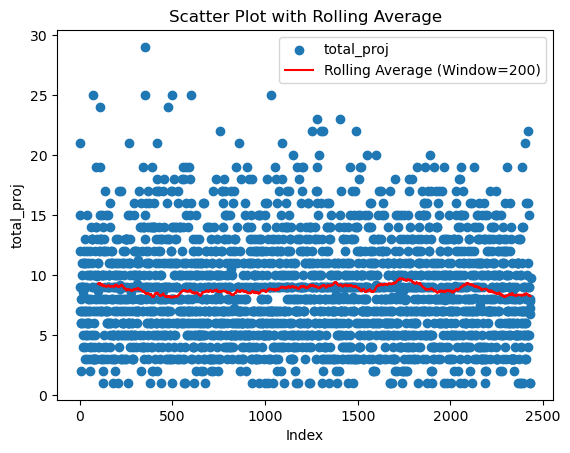

In [34]:
# Total: Choose Vegas or Actual to compare my runs to 
# total = "TotalVegasRuns"
total = "total_act"

complete_gambling_df = complete_gambling_df.sort_values('date', ascending=True).reset_index(drop=True)

# You can convert the index to a list for the x-axis and get the values for the y-axis
x_values = complete_gambling_df.index.tolist()
y_values = complete_gambling_df['total_proj'].tolist()

# Calculate the rolling average
rolling_avg = complete_gambling_df[f'{total}'].rolling(window=200, min_periods=100).mean()

# Create a scatter plot
plt.scatter(x_values, y_values, label='total_proj')

# Add the rolling average line
plt.plot(x_values, rolling_avg, color='red', label='Rolling Average (Window=200)')

# Set labels and title
plt.xlabel('Index')
plt.ylabel('total_proj')
plt.title('Scatter Plot with Rolling Average')
plt.legend()

# Show the plot
plt.show()

Comparing my projections vs. Vegas vs. Actual

In [35]:
complete_gambling_df[['VisitorModelRuns', 'HomeModelRuns', 'VisitorVegasRuns', 'HomeVegasRuns', 
                      'away_score_act', 'home_score_act', 
                      'VisitorModelSqError', 'HomeModelSqError', 'VisitorVegasSqError', 'HomeVegasSqError']].describe()

,VisitorModelRuns,HomeModelRuns,VisitorVegasRuns,HomeVegasRuns,away_score_act,home_score_act,VisitorModelSqError,HomeModelSqError,VisitorVegasSqError,HomeVegasSqError
count,2434.000000,2434.000000,2363.000000,2363.000000,2434.000000,2434.000000,2434.000000,2434.000000,2363.000000,2363.000000
mean,4.368014,4.221149,3.900031,4.201940,4.409203,4.378800,19.075086,17.322817,10.058134,8.910385
std,3.051014,2.855201,1.026147,0.880009,3.158144,3.010650,30.639701,27.042680,18.625436,15.522287
min,0.000000,0.000000,1.175510,1.439394,0.000000,0.000000,0.000000,0.000000,0.000047,0.000001
25%,2.000000,2.000000,3.257143,3.642857,2.000000,2.000000,1.000000,1.000000,0.878590,0.939713
50%,4.000000,4.000000,3.835540,4.222243,4.000000,4.000000,9.000000,9.000000,4.084192,3.869756
75%,6.000000,6.000000,4.457143,4.843064,6.000000,6.000000,25.000000,25.000000,11.508609,10.456092
max,19.000000,20.000000,11.363265,6.924542,20.000000,20.000000,289.000000,324.000000,219.523532,243.365789


In [36]:
complete_gambling_df.shape

(2434, 91)

In [37]:
# Create dataframe
scoring_df = pd.DataFrame(complete_gambling_df[['VisitorModelRuns', 'HomeModelRuns', 'VisitorVegasRuns', 'HomeVegasRuns', 'away_score_act', 'home_score_act', 
                                                'VisitorModelSqError', 'HomeModelSqError', 'VisitorVegasSqError', 'HomeVegasSqError']].mean()).T
# Concatenate model information
scoring_df = pd.concat([model_df, scoring_df], axis=1)
# Write to csv
scoring_df.to_csv(os.path.join(baseball_path, "C01. Gambling", "2. Scoring", f"Scoring Log {todaysdate}.csv"), index=False)

In [38]:
complete_gambling_df['UnderdogSpreadPred'] = np.where(complete_gambling_df['Spread'] < 0, complete_gambling_df['AwaySpreadPred'], complete_gambling_df['HomeSpreadPred'])
complete_gambling_df['FavoriteSpreadPred'] = np.where(complete_gambling_df['Spread'] < 0, complete_gambling_df['HomeSpreadPred'], complete_gambling_df['AwaySpreadPred'])

In [39]:
complete_gambling_df['UnderdogSpreadAct'] = np.where(complete_gambling_df['Spread'] < 0, complete_gambling_df['AwaySpreadAct'], complete_gambling_df['HomeSpreadAct'])
complete_gambling_df['FavoriteSpreadAct'] = np.where(complete_gambling_df['Spread'] < 0, complete_gambling_df['HomeSpreadAct'], complete_gambling_df['AwaySpreadAct'])

In [40]:
complete_gambling_df[['OverPred', 'OverAct', 'UnderPred', 'UnderAct', 'AwayMLPred', 'AwayMLAct', 'HomeMLPred', 'HomeMLAct', 
                      'AwaySpreadPred', 'AwaySpreadAct', 'HomeSpreadPred', 'HomeSpreadAct', 'UnderdogSpreadPred', 'UnderdogSpreadAct', 'FavoriteSpreadPred', 'FavoriteSpreadAct']].describe()

,OverPred,OverAct,UnderPred,UnderAct,AwayMLPred,AwayMLAct,HomeMLPred,HomeMLAct,AwaySpreadPred,AwaySpreadAct,HomeSpreadPred,HomeSpreadAct,UnderdogSpreadPred,UnderdogSpreadAct,FavoriteSpreadPred,FavoriteSpreadAct
count,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000,2363.000000
mean,0.945929,0.971928,0.961075,0.934570,1.019413,0.973092,0.926944,0.938333,0.999292,0.977842,0.903635,0.936249,1.006937,0.949004,0.895991,0.965087
std,0.913822,0.921324,0.935854,0.943817,1.070479,1.055554,0.928616,0.923466,0.961485,0.977274,0.992367,1.007569,0.815205,0.826458,1.114947,1.134884
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.250000,1.363636,1.476190,1.476190,0.000000,0.000000,1.526316,1.500000,0.000000,0.000000
75%,1.869565,1.869565,1.909091,1.909091,2.000000,1.952381,1.769231,1.740741,1.800000,1.769231,1.769231,1.833333,1.645161,1.645161,2.150000,2.200000
max,2.000000,2.000000,2.050000,2.050000,3.600000,4.100000,3.400000,3.700000,2.850000,3.400000,3.000000,3.000000,2.300000,2.200000,3.000000,3.400000


In [41]:
complete_gambling_df['HomeModelAdvantage'] = complete_gambling_df['HomeModelRuns'] - complete_gambling_df['VisitorModelRuns'] 
complete_gambling_df['HomeVegasAdvantage'] = complete_gambling_df['HomeVegasRuns'] - complete_gambling_df['VisitorVegasRuns'] 